Sezione 1: Caricamento Dati


In [3]:
# Import delle librerie necessarie
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime

# Percorsi dei file di input
ois_file_path = 'Dati\EURESTOIS=.xlsm'
forwards_ois_ecb_file_path = 'Dati\EUESTECBF=ICAP.xlsm'
deposit_file_path = 'Dati\EURDEPO=.xlsm'
fra_file_path = 'Dati\EUR6MFRA=.xlsm'
swap_file_path = 'Dati\EURAB6EIRS=.xlsm'
zcswap_file_path = 'Dati\EURAB6EIRSZ=FMD.xlsm'

ecb_maintenance_periods = {
    "JAN24": {"start": ql.Date(31, ql.January, 2024), "end": ql.Date(12, ql.March, 2024)},
    "MAR24": {"start": ql.Date(13, ql.March, 2024), "end": ql.Date(16, ql.April, 2024)},
    "APR24": {"start": ql.Date(17, ql.April, 2024), "end": ql.Date(11, ql.June, 2024)},
    "JUN24": {"start": ql.Date(12, ql.June, 2024), "end": ql.Date(23, ql.July, 2024)},
    "JUL24": {"start": ql.Date(24, ql.July, 2024), "end": ql.Date(17, ql.September, 2024)},
    "SEP24": {"start": ql.Date(18, ql.September, 2024), "end": ql.Date(22, ql.October, 2024)},
    "OCT24": {"start": ql.Date(23, ql.October, 2024), "end": ql.Date(17, ql.December, 2024)},
    "DEC24": {"start": ql.Date(18, ql.December, 2024), "end": "tbd"}
}


# Funzione per leggere i dati e calcolare i tassi medi
def load_and_process_data(file_path, sheet_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
    data['Mid_Rate'] = (data['Bid'] + data['Ask']) / 2
    return data

# Carica e processa i dati
ois_data = load_and_process_data(ois_file_path, 'Sheet1')
forwards_ois_ecb_data = load_and_process_data(forwards_ois_ecb_file_path, 'Sheet1')
deposit_data = load_and_process_data(deposit_file_path, 'Sheet1')
fra_data = load_and_process_data(fra_file_path, 'Sheet1')
swap_data = load_and_process_data(swap_file_path, 'Sheet1')
zcswap_data = load_and_process_data(zcswap_file_path, 'Sheet1')

# Definisco le maturities manualmente sulla base dello studio di Ametrano e Bianchetti
ESTR_curve_deposit_maturities_chosen = ['ON', 'TN', 'SN'] 
fra_maturities_chosen = ['1X7', '2X8', '3X9', '4X10', '5X11', '6X12', '7X13', '8X14', '9X15', '10X16', '11X17', '12X18', '13X19', '14X20', '15X21', '16X22', '17X23', '18X24']
#swap_maturities_chosen = ['3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '11Y', '12Y', '13Y', '14Y', '15Y', '16Y', '17Y', '18Y', '19Y', '20Y', '21Y', '22Y', '23Y', '24Y', '25Y', '26Y', '27Y', '28Y', '29Y', '30Y','40Y','50Y']
swap_maturities_chosen = ['3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']



FileNotFoundError: [Errno 2] No such file or directory: 'Dati\\EUR6MFRA=.xlsm'

Sezione 2: Conversione delle Scadenze in Periodi QuantLib e Impostazione della Data di Valutazione

In [ ]:

# Mappa per convertire il calendario in periodi QuantLib
period_map = {
    "D": ql.Days ,
    "W": ql.Weeks,
    "M": ql.Months,
    "Y": ql.Years
}

# Mappa dei giorni di fixing
fixing_days_map = {
    "ON": 0,
    "TN": 1,
    "SN": 2,
    "SW": 2,
    "2W": 2,
    "3W": 2
}

# Funzione per convertire le maturities in periodi QuantLib gestendo i casi speciali
def convert_to_period(maturity):
    special_maturity_format = {
        "ON": ql.Period(1, ql.Days),
        "TN": ql.Period(2, ql.Days),
        "SN": ql.Period(3, ql.Days),
        "SW": ql.Period(1, ql.Weeks)
    }
    
    if maturity in special_maturity_format:
        return special_maturity_format[maturity]
    
    try:
        if 'X' in maturity:
            start, end = maturity.split('X')
            return ql.Period(int(start), ql.Months), ql.Period(int(end), ql.Months)
        num = int(maturity[:-1])
    except ValueError:
        raise ValueError(f"Formato della scadenza non valido: {maturity}")
    
    unit = maturity[-1]
    return ql.Period(num, period_map[unit])

# Conversione delle maturities in periodi QuantLib
ois_data['Period'] = ois_data['Maturity'].apply(convert_to_period)
#forwards_ois_ecb_data['Start_Period'], forwards_ois_ecb_data['End_Period'] = zip(*forwards_ois_ecb_data['Maturity'].apply(convert_to_period))
deposit_data['Period'] = deposit_data['Maturity'].apply(convert_to_period)
fra_data['Start_Period'], fra_data['End_Period'] = zip(*fra_data['Maturity'].apply(convert_to_period))
swap_data['Period'] = swap_data['Maturity'].apply(convert_to_period)

# Elaborazione dati dei forward OIS ECB nei maintenance period

# Rimuovi i maintenance period non utilizzati
del ecb_maintenance_periods["JAN24"]
del ecb_maintenance_periods["MAR24"]
del ecb_maintenance_periods["APR24"]
del ecb_maintenance_periods["JUN24"]
del ecb_maintenance_periods["DEC24"]

# Rimuovi i forward OIS ECB non utilizzati
forwards_ois_ecb_data = forwards_ois_ecb_data[(forwards_ois_ecb_data.index > 0) & (forwards_ois_ecb_data.index < 4)]

# Setta le date di inizio e fine dei maintenance period e le relative scadenze dei forward OIS ECB
period_keys = list(ecb_maintenance_periods.keys())
forwards_ois_ecb_data['Start_Period'] = [ecb_maintenance_periods[key]['start'] for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data['End_Period'] = [ecb_maintenance_periods[key]['end'] + 1 for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data.drop(columns=['Maturity'], inplace=True)

# DEBUG: Stampa i dati 
DEBUG_DATI = False
if DEBUG_DATI:
    print(f"Deposit Data: {deposit_data}")
    print(f"OIS Data: {ois_data}")
    print(f"Forwards OIS ECB Data: {forwards_ois_ecb_data}")
    print(f"FRA Data: {fra_data}")
    print(f"Swap Data: {swap_data}")

# Imposta la data di valutazione delle curve
settle_date = ql.Date(2, 7, 2024)
ql.Settings.instance().evaluationDate = settle_date


Deposit Data:    Maturity   Bid   Ask  Mid_Rate Period
0        ON  3.66  3.78     3.720     1D
1        TN  3.55  3.90     3.725     2D
2        SN  3.55  3.90     3.725     3D
3        SW  3.66  3.78     3.720     1W
4        2W  3.57  3.67     3.620     2W
5        3W  3.60  3.85     3.725     3W
6        1M  3.56  3.66     3.610     1M
7        2M  3.68  3.98     3.830     2M
8        3M  3.68  3.98     3.830     3M
9        4M  3.64  3.94     3.790     4M
10       5M  3.64  3.94     3.790     5M
11       6M  3.61  3.91     3.760     6M
12       7M  3.71  3.76     3.735     7M
13       8M  3.68  3.74     3.710     8M
14       9M  3.50  3.63     3.565     9M
15      10M  3.47  3.61     3.540    10M
16      11M  3.59  3.64     3.615    11M
17       1Y  3.55  3.85     3.700     1Y
18       2Y  2.99  3.39     3.190     2Y
19       3Y  2.86  3.26     3.060     3Y
20       4Y  2.81  3.21     3.010     4Y
21       5Y  2.78  3.18     2.980     5Y
22       7Y  2.74  3.14     2.940     7Y
23

Sezione 3: Costruzione della Curva di Sconto €STR

  Maturity     Bid     Ask  Mid_Rate Period
0       SW  3.6622  3.6655   3.66385     1W
estr Helpers:
Start Date: July 2nd, 2024, Maturity Date: July 3rd, 2024, Quote: 0.0372
Start Date: July 3rd, 2024, Maturity Date: July 4th, 2024, Quote: 0.03725
Start Date: July 4th, 2024, Maturity Date: July 5th, 2024, Quote: 0.03725
Start Date: July 4th, 2024, Maturity Date: July 11th, 2024, Quote: 0.0366385
Start Date: July 24th, 2024, Maturity Date: September 18th, 2024, Quote: 0.03662
Start Date: September 18th, 2024, Maturity Date: October 23rd, 2024, Quote: 0.03451
Start Date: October 23rd, 2024, Maturity Date: December 18th, 2024, Quote: 0.0338
Start Date: July 4th, 2024, Maturity Date: May 5th, 2025, Quote: 0.033375
Start Date: July 4th, 2024, Maturity Date: June 4th, 2025, Quote: 0.033025
Start Date: July 4th, 2024, Maturity Date: July 4th, 2025, Quote: 0.032645
Start Date: July 4th, 2024, Maturity Date: October 6th, 2025, Quote: 0.031435000000000005
Start Date: July 4th, 2024, Maturity Da

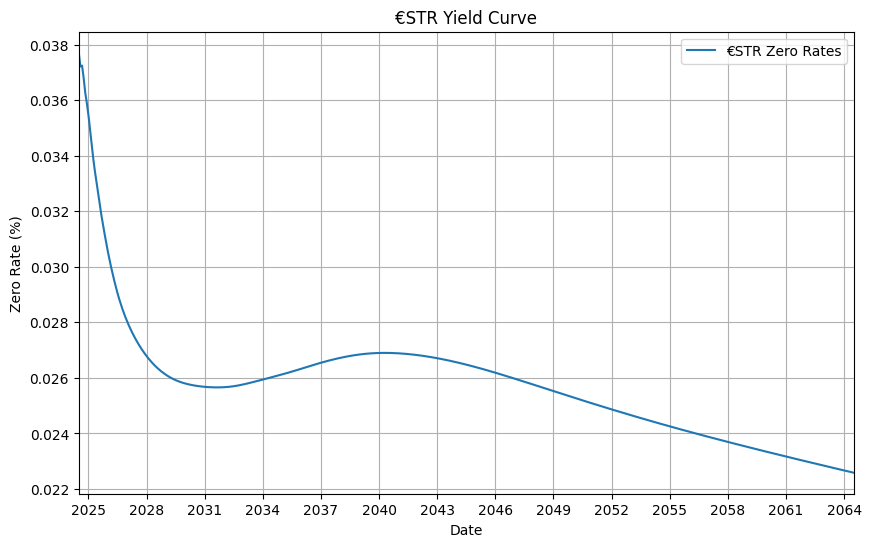

In [ ]:

# Inizializza una lista vuota per contenere gli helpers della curva €STR
estr_helpers = []

# Inizializzo la curva €STR
estr = ql.Estr()

# 1) Depositi
# Aggiungo gli helpers per la prima parte della curva dai depositi selezionati
selected_data = deposit_data[deposit_data['Maturity'].isin(ESTR_curve_deposit_maturities_chosen)]

estr_helpers += [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
        ql.Period(1, ql.Days),
        fixing_days_map[row['Maturity']],
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360()
    )
    for _, row in selected_data.iterrows()
]


# 2) OIS pre-ECB

ois_pre_ecb = ois_data[ois_data.index < 1] # Attenzione all'overlapping con i forward OIS ECB
print(ois_pre_ecb)
# Aggiungo gli helpers per la seconda parte della curva dagli OIS pre-ECB selezionati
estr_helpers += [
    ql.OISRateHelper(
        2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
    )
    for index, row in ois_pre_ecb.iterrows()
]

# 3) Forward OIS ECB dates
# Aggiungo gli helpers per la terza parte della curva dai Forward OIS ECB selezionati

estr_helpers += [
    ql.DatedOISRateHelper(
        row['Start_Period'], row['End_Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
    )
    for index, row in forwards_ois_ecb_data.iterrows()
]

# 4) OIS post-ECB
ois_post_ecb = ois_data[ois_data.index > 11] # Attenzione all'overlapping con i forward OIS ECB
estr_helpers += [
    ql.OISRateHelper(
        2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
    )
    for index, row in ois_post_ecb.iterrows()
]


# DEBUG: Stampa i dettagli di tutti gli helpers
DEBUG_ESTR = False
if DEBUG_ESTR:
    print("estr Helpers:")
    for helper in estr_helpers:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

#================================================================================================
# Costruisco la curva di sconto €STR
estr_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), estr_helpers, ql.Actual365Fixed())
estr_curve.enableExtrapolation() # Abilita l'extrapolazione per le date oltre l'ultima data disponibile

# Calcolo i fattori di sconto per le date specificate
dates = [settle_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]
discount_factors = [estr_curve.discount(date) for date in dates] ###### check this

# Funzione per convertire le date di QuantLib in datetime per matplotlib
def _to_datetime(_date):
    return datetime(_date.year(), _date.month(), _date.dayOfMonth())

# Conversione delle date in formato datetime
dates_dt = [_to_datetime(date) for date in dates]
zero_rates = [
    estr_curve.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate() # check
    for date in dates
]

# Creazione del grafico della curva €STR
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, zero_rates, label='€STR Zero Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Zero Rate (%)')
plt.title('€STR Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


Sezione 4: ECB Liquidity check Jumps

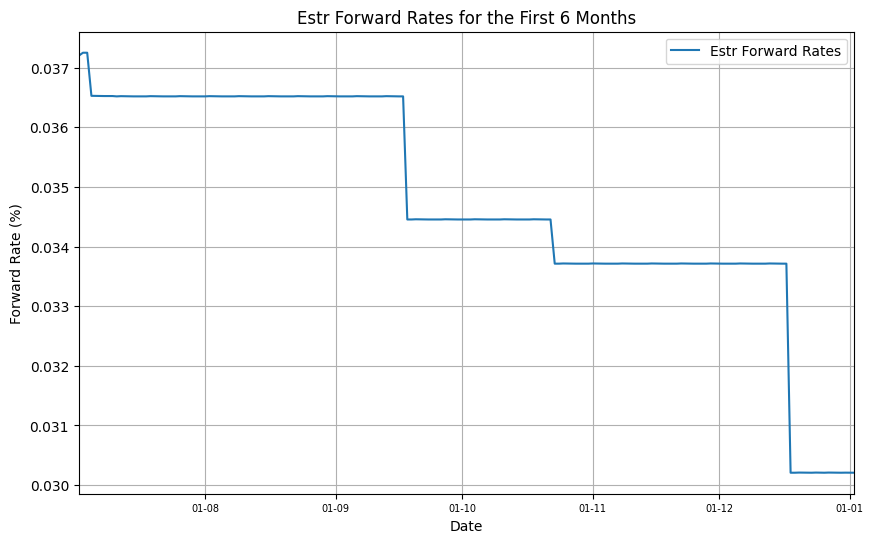

In [ ]:


#To simplify analysis, we turn to flat forward rates instead of log-cubic discounts; thus
estr_curve_ff = ql.PiecewiseFlatForward(
    0, ql.TARGET(), estr_helpers, ql.Actual365Fixed()
)
estr_curve_ff.enableExtrapolation()

# Restrict the plot to the first 6 months
end = ql.TARGET().advance(settle_date, ql.Period(6, ql.Months))

# Calculate the forward rates for the first 6 months
dates = [
    ql.Date(serial)
    for serial in range(settle_date.serialNumber(), end.serialNumber() + 1)
]

rates_ff = [
    estr_curve_ff.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Convert QuantLib dates to datetime
dates_dt = [d.to_date() for d in dates]

plt.figure(figsize=(10, 6))
plt.plot(dates_dt, rates_ff, label='Estr Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gca().tick_params(axis='x', labelsize=7)  # Set the x-axis label size to be smaller
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('Estr Forward Rates for the First 6 Months')
plt.legend()
plt.grid(True)
plt.show()

Sezione 5: Costruzione della Curva Euribor a 6 Mesi - Biased

euribor  Helpers:
Start Date: July 5th, 2024, Maturity Date: January 6th, 2025, Quote: 0.037599999999999995
Start Date: August 5th, 2024, Maturity Date: February 4th, 2025, Quote: 0.035629999999999995
Start Date: September 4th, 2024, Maturity Date: March 4th, 2025, Quote: 0.03463
Start Date: October 4th, 2024, Maturity Date: April 4th, 2025, Quote: 0.033780000000000004
Start Date: November 4th, 2024, Maturity Date: May 5th, 2025, Quote: 0.03291
Start Date: December 4th, 2024, Maturity Date: June 4th, 2025, Quote: 0.03216
Start Date: January 6th, 2025, Maturity Date: July 4th, 2025, Quote: 0.03144
Start Date: February 4th, 2025, Maturity Date: August 4th, 2025, Quote: 0.03069
Start Date: March 4th, 2025, Maturity Date: September 4th, 2025, Quote: 0.03
Start Date: April 4th, 2025, Maturity Date: October 6th, 2025, Quote: 0.029379999999999996
Start Date: May 5th, 2025, Maturity Date: November 4th, 2025, Quote: 0.028840000000000005
Start Date: June 4th, 2025, Maturity Date: December 4th, 2

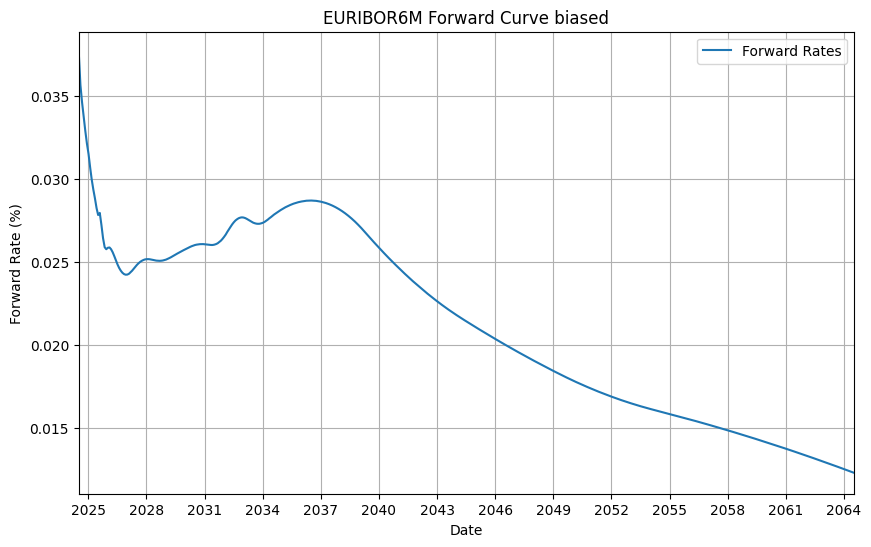

In [ ]:

# Definisco l'istanza di Euribor a 6 mesi
euribor6m = ql.Euribor6M()

# 1) Depositi
# Primo pillar della curva EURIBOR: il deposito a 6 mesi
first_pillar_6m_deposit = deposit_data['Mid_Rate'][deposit_data['Maturity'] == '6M'].values[0]

deposit_helper_6m = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(first_pillar_6m_deposit / 100)),
        ql.Period(6, ql.Months),
        3,  # 3 giorni di fixing
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
]

# 2) FRA
# Aggiungo gli helpers per la seconda parte della curva dai FRA (2 anni)
fra_helpers = []
for index, row in fra_data.iterrows():
    fra_helpers.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                     row['Start_Period'], euribor6m))

# Utilizzo €STR come curva di sconto per l'approccio dual curve
discount_curve = ql.YieldTermStructureHandle(estr_curve)

# 3) SWAP
# Aggiungo gli helpers per la terza parte della curva dai SWAP
swap_helpers_dual = []
selected_data = swap_data[swap_data['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_dual.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))
    
# Debug: Stampa i dettagli di tutti gli helpers EURIBOR biased
DEBUG_EUR = True
if DEBUG_EUR:
    euribor_helpers = deposit_helper_6m + fra_helpers + swap_helpers_dual
    print("euribor  Helpers:")
    for helper in euribor_helpers:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisce la curva EURIBOR biased
euribor6m_curve_biased = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), deposit_helper_6m + fra_helpers + swap_helpers_dual, ql.Actual365Fixed()
)
euribor6m_curve_biased.enableExtrapolation()

# Costruisco la curva forward EURIBOR biased
spot_date = euribor6m_curve_biased.referenceDate()  # Imposta la data di valutazione come data spot
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 40 * 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]

euribor6m_f_curve_dual_biased = [
    euribor6m_curve_biased.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico della curva forward EURIBOR biased
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, euribor6m_f_curve_dual_biased, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve biased')
plt.legend()
plt.grid(True)
plt.show()


Sezione 6: Calcolo del Basis e Creazione di Depositi Sintetici

In [ ]:


# Imposto la data spot a un giorno dopo la data di regolamento (convenzione fixing)
d = ql.TARGET().advance(spot_date, 1, ql.Days)

# Bootsrap del tasso forward a 6 mesi dalla curva EURIBOR a 6 mesi preesistente
euribor6m_forward_curve_biased = euribor6m_curve_biased.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap del tasso forward a 6 mesi dalla curva €STR
F_estr = estr_curve.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Convenzione di conteggio giorni utilizzata dalla curva EURIBOR a 6 mesi
day_counter = euribor6m.dayCounter()

# Calcolo la frazione di anno tra la data d e 6 mesi dopo usando la convenzione di conteggio giorni
euribor6M_YFraction = day_counter.yearFraction(d, ql.TARGET().advance(d, 6, ql.Months))

# Calcolo lo spread (alpha) tra il tasso forward EURIBOR a 6 mesi e il tasso forward €STR
alpha = euribor6m_forward_curve_biased - F_estr
print(f"alpha: {alpha}")

# Cosrtuzione degli helpers per depositi sintetici 
synth_deposit_helper_ON_to_5M = []

# Definisco una lista di tuple che rappresentano le maturities per le quali verranno creati depositi sintetici
# Ogni tupla contiene un numero (n) e un'unità di tempo (Days, Weeks, ql.Months)
for n, units in [
    (1, ql.Days),
    (1, ql.Weeks),
    (2, ql.Weeks),
    (3, ql.Weeks),
    (1, ql.Months),
    (2, ql.Months),
    (3, ql.Months),
    (4, ql.Months),
    (5, ql.Months),
]:
    t = day_counter.yearFraction(spot_date, ql.TARGET().advance(spot_date, n, units))  # Calcola la frazione di anno tra la data spot e la data di scadenza usando la convenzione di conteggio giorni
    
    # Calcolo il tasso forward dalla curva €STR per la durata data e aggiusto il tasso forward Euribor aggiungendo lo spread precedentemente calcolato (alpha)
    F_estr = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
    ).rate()
    
    F_eu = F_estr + alpha

    # Crea un helper per deposito sintetico con il tasso forward calcolato e aggiungilo alla lista
    synth_deposit_helper_ON_to_5M.append(
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(F_eu)),  # Il tasso forward aggiustato
            ql.Period(n, units),               # La durata per il deposito sintetico
            2,                              # Giorni di regolamento
            ql.TARGET(),                       # Calendario
            ql.Following,                      # Convenzione di giorno lavorativo
            False,                          # Flag di fine mese
            ql.Actual360(),                    # Convenzione di conteggio giorni
        )
    )

# DEBUG: Stampa i dettagli di ogni helper per deposito sintetico
DEBUG_SYNTH = True
if DEBUG_SYNTH:
    print("Synthetic Deposit Helpers:")
    for helper in synth_deposit_helper_ON_to_5M:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")


alpha: 0.002444684146503319
Synthetic Deposit Helpers:
Start Date: July 4th, 2024, Maturity Date: July 5th, 2024, Quote: 0.039694684146567495
Start Date: July 4th, 2024, Maturity Date: July 11th, 2024, Quote: 0.03908318414650277
Start Date: July 4th, 2024, Maturity Date: July 18th, 2024, Quote: 0.03900295805980317
Start Date: July 4th, 2024, Maturity Date: July 25th, 2024, Quote: 0.03906956477855697
Start Date: July 4th, 2024, Maturity Date: August 5th, 2024, Quote: 0.0391920899199407
Start Date: July 4th, 2024, Maturity Date: September 4th, 2024, Quote: 0.039260104619141464
Start Date: July 4th, 2024, Maturity Date: October 4th, 2024, Quote: 0.03884287338641054
Start Date: July 4th, 2024, Maturity Date: November 4th, 2024, Quote: 0.038366695335572715
Start Date: July 4th, 2024, Maturity Date: December 4th, 2024, Quote: 0.0380490663723631


Sezione 7: Costruzione della Curva Forward Euribor Corretta

Euribor corretto helpers:
Start Date: July 4th, 2024, Maturity Date: July 5th, 2024, Quote: 0.039694684146567495
Start Date: July 4th, 2024, Maturity Date: July 11th, 2024, Quote: 0.03908318414650277
Start Date: July 4th, 2024, Maturity Date: July 18th, 2024, Quote: 0.03900295805980317
Start Date: July 4th, 2024, Maturity Date: July 25th, 2024, Quote: 0.03906956477855697
Start Date: July 4th, 2024, Maturity Date: August 5th, 2024, Quote: 0.0391920899199407
Start Date: July 4th, 2024, Maturity Date: September 4th, 2024, Quote: 0.039260104619141464
Start Date: July 4th, 2024, Maturity Date: October 4th, 2024, Quote: 0.03884287338641054
Start Date: July 4th, 2024, Maturity Date: November 4th, 2024, Quote: 0.038366695335572715
Start Date: July 4th, 2024, Maturity Date: December 4th, 2024, Quote: 0.0380490663723631
Start Date: July 5th, 2024, Maturity Date: January 6th, 2025, Quote: 0.037599999999999995
Start Date: August 5th, 2024, Maturity Date: February 4th, 2025, Quote: 0.03562999999999

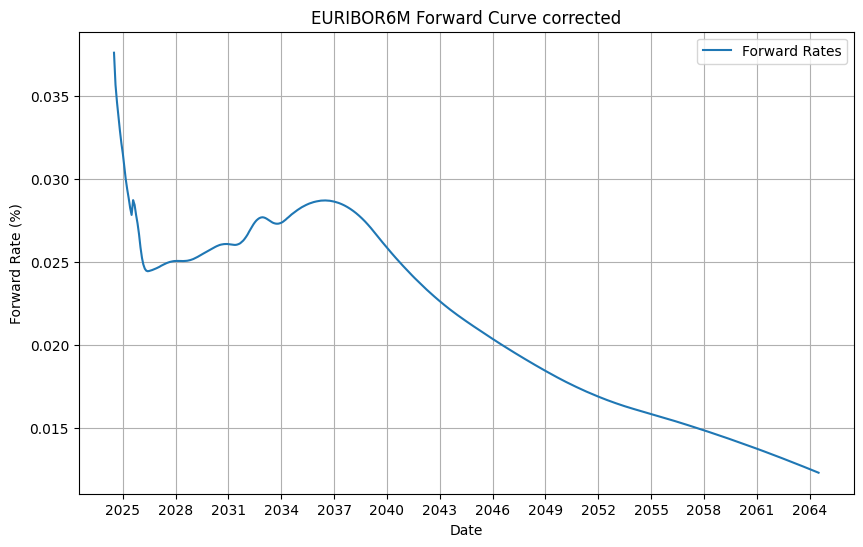

In [ ]:

# Costruisco la curva EURIBOR corretta usando gli helpers per i depositi sintetici
euribor6m_f_curve_corrected = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + deposit_helper_6m + fra_helpers + swap_helpers_dual, ql.Actual365Fixed()
)
euribor6m_f_curve_corrected.enableExtrapolation()

# DEBUG: Stampa i dettagli degli helpers per la curva EURIBOR corretta
DEBUG_EU_CORR = True
if DEBUG_EU_CORR:
    print("Euribor corretto helpers:")
    for helper in synth_deposit_helper_ON_to_5M+ deposit_helper_6m + fra_helpers + swap_helpers_dual:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisco la curva forward EURIBOR corretta
euribor6m_f_curve_dual = [
    euribor6m_f_curve_corrected.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico della curva forward EURIBOR corretta
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, euribor6m_f_curve_dual, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve corrected')
plt.legend()
plt.grid(True)
plt.show()


Sezione 8: Costruzione della Curva Forward Euribor con Approccio Single Curve

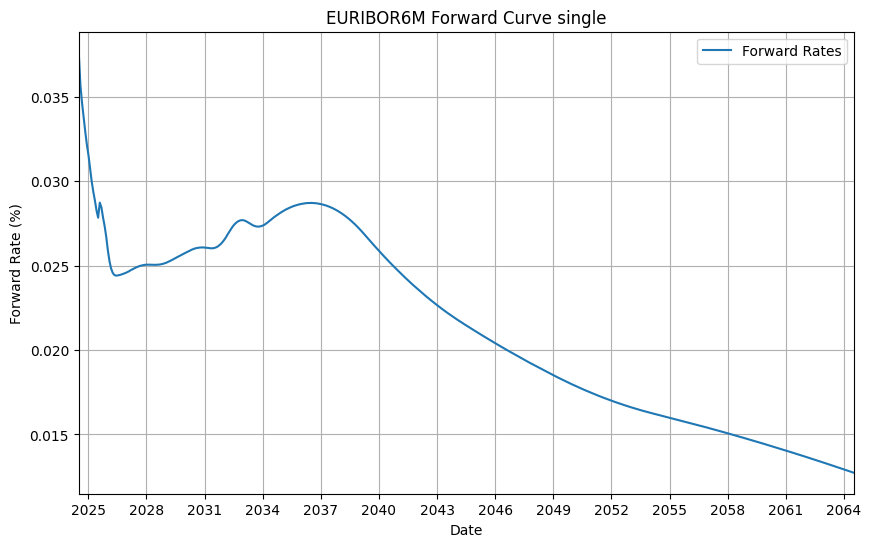

In [ ]:

# Aggiungo gli helpers per la curva single curve dagli SWAP, utilizzando la curva euribor implcita per il discounting
swap_helpers_single = []
selected_data = swap_data[swap_data['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_single.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days)))

# Costruisco la curva EURIBOR single curve usando gli helpers per i depositi sintetici, i depositi, i FRA e gli SWAP single curve
euribor6m_f_curve_single = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + deposit_helper_6m + fra_helpers + swap_helpers_single, ql.Actual365Fixed()
)
euribor6m_f_curve_single.enableExtrapolation()

# Costruisco la curva forward EURIBOR single curve
f_rates_eu_single = [
    euribor6m_f_curve_single.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico della curva forward EURIBOR single curve
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, f_rates_eu_single, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve single')
plt.legend()
plt.grid(True)
plt.show()


Sezione 9: Calcolo e Confronto delle Curve Forward EURIBOR a 6 Mesi


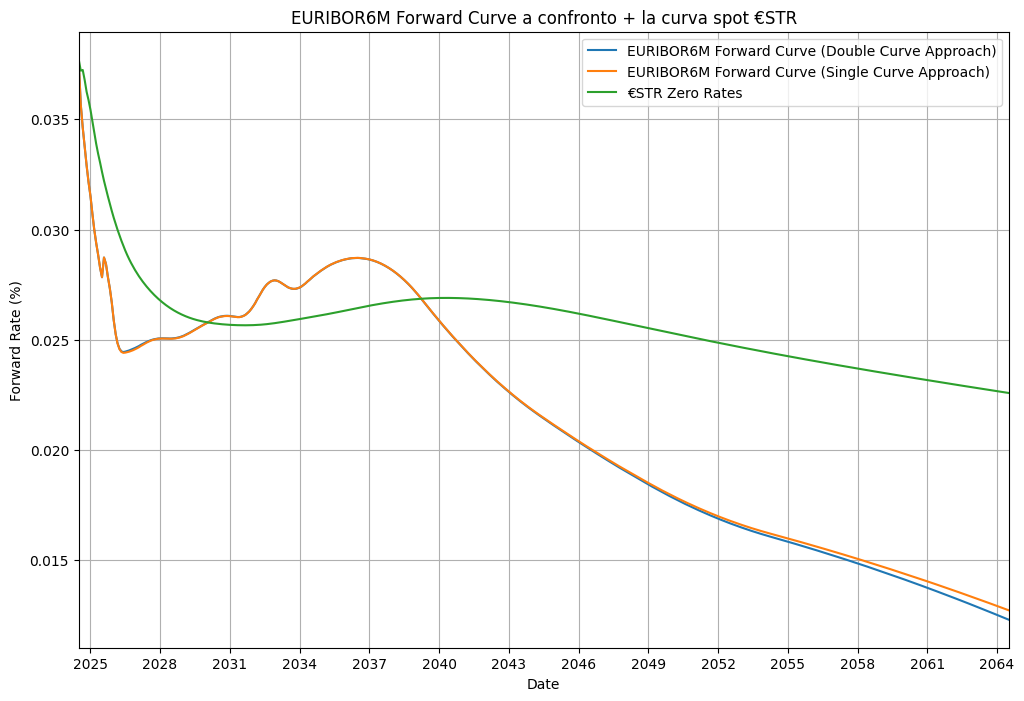

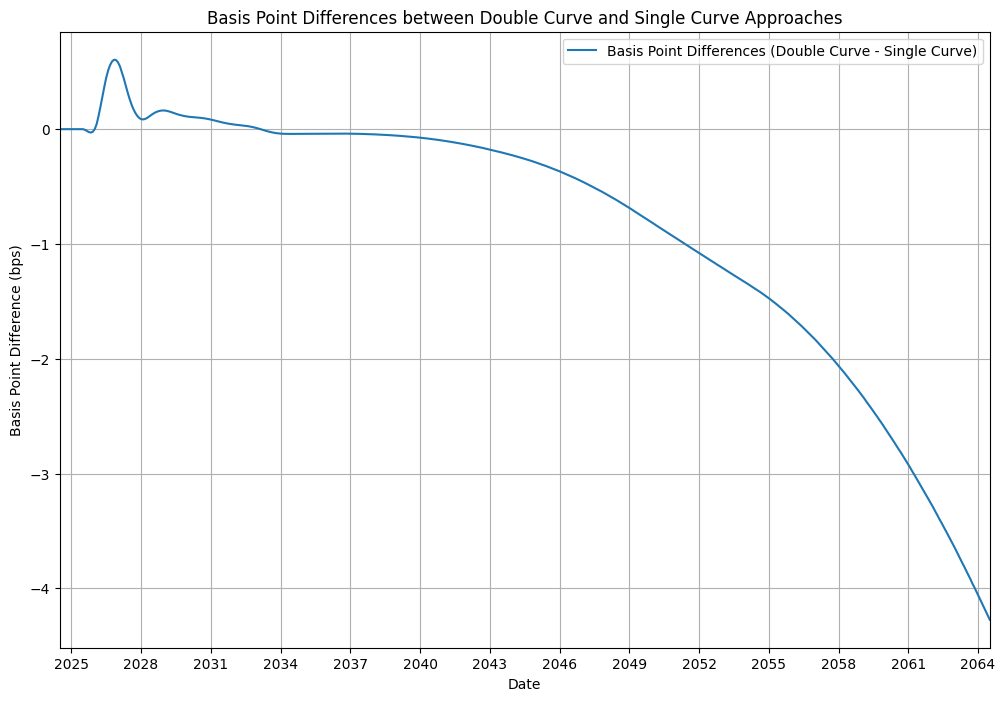

In [ ]:

# Calcola le differenze in basis points tra le curve forward dual curve e single curve
basis_point_differences = [
    (d, (fr_dual - fr_single) * 10000)
    for d, fr_single, fr_dual in zip(dates, f_rates_eu_single, euribor6m_f_curve_dual)
]

# Estrai le date e le differenze in basis points per il grafico
basis_dates, bp_diffs = zip(*basis_point_differences)

# Grafico delle curve forward EURIBOR6M
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, euribor6m_f_curve_dual, label='EURIBOR6M Forward Curve (Double Curve Approach)')
plt.plot(dates_dt, f_rates_eu_single, label='EURIBOR6M Forward Curve (Single Curve Approach)')
plt.plot(dates_dt, zero_rates, label='€STR Zero Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([dates_dt[0], dates_dt[-1]])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Curve a confronto + la curva spot €STR')
plt.legend()
plt.grid(True)
plt.show()

# Grafico delle differenze in basis points
plt.figure(figsize=(12, 8))
plt.plot(dates_dt, bp_diffs, label='Basis Point Differences (Double Curve - Single Curve)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Basis Point Difference (bps)')
plt.title('Basis Point Differences between Double Curve and Single Curve Approaches')
plt.legend()
plt.grid(True)
plt.show()


Sezione 10: confronto tra diverse curve

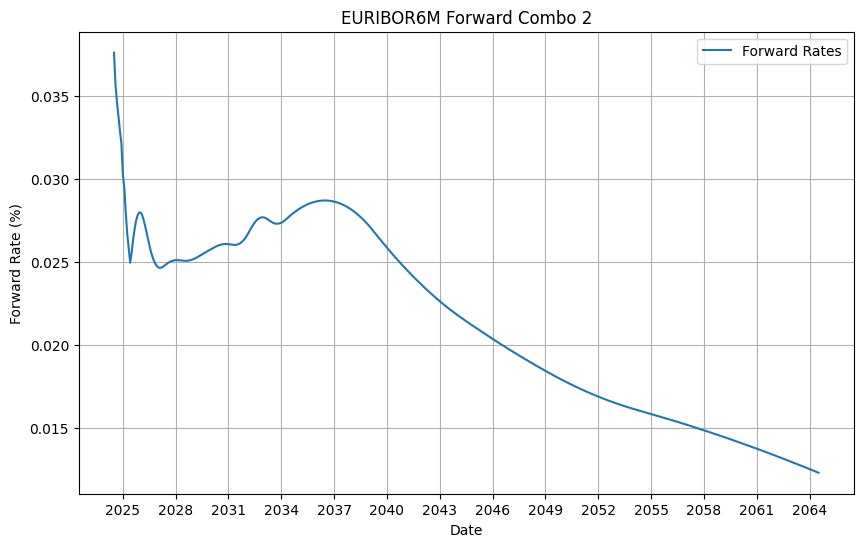

Euribor combo 3 helpers:
Start Date: July 4th, 2024, Maturity Date: July 5th, 2024, Quote: 0.039694684146567495
Start Date: July 4th, 2024, Maturity Date: July 11th, 2024, Quote: 0.03908318414650277
Start Date: July 4th, 2024, Maturity Date: July 18th, 2024, Quote: 0.03900295805980317
Start Date: July 4th, 2024, Maturity Date: July 25th, 2024, Quote: 0.03906956477855697
Start Date: July 4th, 2024, Maturity Date: August 5th, 2024, Quote: 0.0391920899199407
Start Date: July 4th, 2024, Maturity Date: September 4th, 2024, Quote: 0.039260104619141464
Start Date: July 4th, 2024, Maturity Date: October 4th, 2024, Quote: 0.03884287338641054
Start Date: July 4th, 2024, Maturity Date: November 4th, 2024, Quote: 0.038366695335572715
Start Date: July 4th, 2024, Maturity Date: December 4th, 2024, Quote: 0.0380490663723631
Start Date: July 5th, 2024, Maturity Date: January 6th, 2025, Quote: 0.037599999999999995
Start Date: July 4th, 2024, Maturity Date: July 4th, 2025, Quote: 0.03475
Start Date: Jul

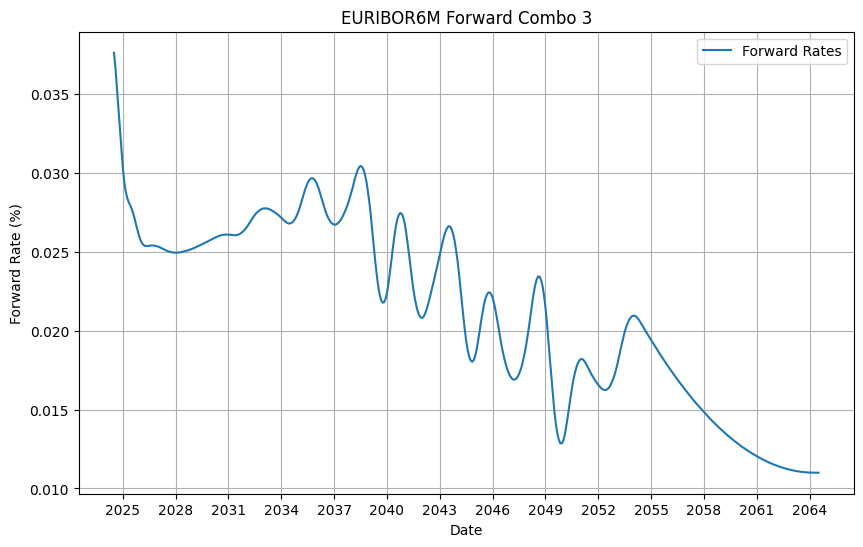

In [ ]:
# Combinazione 2: Maggiore focus su swap
fra_maturities_chosen_combo2 = ['1X7', '2X8', '3X9', '4X10', '5X11']
swap_maturities_chosen_combo2 = ['1Y','18','2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']

# DEPOSITI e DEPOSITI SINTETICI sono gli stessi della combinazione 1

# FRA
selected_data = fra_data[fra_data['Maturity'].isin(fra_maturities_chosen_combo2)]
fra_helpers_combo2 = []
for index, row in selected_data.iterrows():
    fra_helpers_combo2.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                     row['Start_Period'], euribor6m))

# Utilizzo €STR come curva di sconto per l'approccio dual curve
discount_curve = ql.YieldTermStructureHandle(estr_curve)

# SWAP
swap_helpers_combo2 = []
selected_data = swap_data[swap_data['Maturity'].isin(swap_maturities_chosen_combo2)]
for index, row in selected_data.iterrows():
    swap_helpers_combo2.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))
    
# DEBUG: Stampa i dettagli degli helpers per la curva EURIBOR combo 2
DEBUG_EU_COMBO2 = False
if DEBUG_EU_COMBO2:
    print("Euribor combo 2 helpers:")
    for helper in synth_deposit_helper_ON_to_5M + deposit_helper_6m + fra_helpers_combo2 + swap_helpers_combo2:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisco la curva EURIBOR 
euribor6m_curve_combo2 = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + deposit_helper_6m + fra_helpers_combo2 + swap_helpers_combo2, ql.Actual365Fixed()
)
euribor6m_curve_combo2.enableExtrapolation()


# Costruisco la curva forward EURIBOR

euribor6m_f_curve_combo2 = [
    euribor6m_curve_combo2.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, euribor6m_f_curve_combo2, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Combo 2')
plt.legend()
plt.grid(True)
plt.show()


# Combinazione 3:Depositi e zc swap
zcswap_maturities_chosen_combo3 = ['9M', '1Y','15M', '18M','21M', '2Y','30M', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y']



# DEPOSITI e DEPOSITI SINTETICI sono gli stessi della combinazione 1

# SWAP
zcswap_helpers_combo3 = []
for index, row in swap_data.iterrows():
    zcswap_helpers_combo3.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Once, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))

DEBUG_EU_COMBO3 = True
if DEBUG_EU_COMBO3:
    print("Euribor combo 3 helpers:")
    for helper in synth_deposit_helper_ON_to_5M + deposit_helper_6m + zcswap_helpers_combo3:
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

# Costruisco la curva EURIBOR
euribor6m_curve_combo3 = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + deposit_helper_6m + zcswap_helpers_combo3, ql.Actual365Fixed()
)

euribor6m_curve_combo3.enableExtrapolation()

# Costruisco la curva forward EURIBOR

euribor6m_f_curve_combo3 = [
    euribor6m_curve_combo3.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(dates_dt, euribor6m_f_curve_combo3, label='Forward Rates')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('EURIBOR6M Forward Combo 3')
plt.legend()
plt.grid(True)
plt.show()






